## Documentation

To read more about the Time Series Data Stream, checkout the docs [here](https://www.elastic.co/guide/en/elasticsearch/reference/current/tsds.html).

![time_series_docs](../images/time_series_docs.png)

## Connect to ElasticSearch

In [7]:
from pprint import pprint
from elasticsearch import Elasticsearch

es = Elasticsearch('http://localhost:9200')
client_info = es.info()
print('Connected to Elasticsearch!')
pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'DlYG5m9gR3upn7qgaYyAJA',
 'name': '3d37442d2591',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2024-08-05T10:05:34.233336849Z',
             'build_flavor': 'default',
             'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '9.11.1',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.17.0',
             'number': '8.15.0'}}


## ILM policy

If you want to modify other phases of the policy, check this [example](https://www.elastic.co/guide/en/elasticsearch/reference/current/set-up-tsds.html#tsds-ilm-policy) in the docs.

In [12]:
from pprint import pprint

policy = {
    "phases": {
        "hot": {
            "actions": {
                "rollover": {
                    "max_age": "5m",
                }
            }
        },
        "delete": {
            "min_age": "20m",
            "actions": {
                "delete": {}
            }
        }
    }
}

response = es.ilm.put_lifecycle(name="cpu_usage_policy", policy=policy)
pprint(response.body)

{'acknowledged': True}


## Index template

In [ ]:
if es.indices.exists(index="cpu_usage_data"):
    es.indices.delete(index="cpu_usage_data")

response = es.indices.create_data_stream(name="cpu_usage_data")
print(response)

{'acknowledged': True}


In [32]:
response = es.indices.put_index_template(
    name="cpu_usage_template",
    index_patterns=[
        "cpu_usage_data*"  # Applies to any index starting with 'cpu_usage_data'
    ],
    data_stream={},
    template={
        "settings": {
            "index.mode": "time_series",  # Enable time series data mode
            "index.lifecycle.name": "cpu_usage_policy",  # Apply the ILM policy
        },
        "mappings": {
            "properties": {
                "@timestamp": {
                    "type": "date"
                },
                "cpu_usage": {
                    "type": "float",
                    "time_series_metric": "gauge"
                },
                "cpu_name": {
                    "type": "keyword",
                    "time_series_dimension": True
                }
            }
        }
    },
    priority=500,  # A priority higher than 200 to avoid collisions with built-in templates
    meta={
        "description": "Template for CPU usage data",
    },
    allow_auto_create=True
)
pprint(response.body)

{'acknowledged': True}


## Index data

In [56]:
import psutil
from datetime import datetime


index_alias = "cpu_usage_data"
counter = 0
while counter < 100:
    cpu_usage = psutil.cpu_percent(interval=0.1)
    timestamp = datetime.utcnow()

    document = {
        "@timestamp": timestamp,
        "cpu_usage": cpu_usage,
        "cpu_name": "i7-13650HX"
    }

    es.index(index=index_alias, document=document, refresh=True)
    counter += 1

In [59]:
response = es.indices.get_data_stream()
pprint(response.body)

{'data_streams': [{'_meta': {'description': 'Template for CPU usage data'},
                   'allow_custom_routing': False,
                   'generation': 1,
                   'hidden': False,
                   'ilm_policy': 'cpu_usage_policy',
                   'indices': [{'ilm_policy': 'cpu_usage_policy',
                                'index_name': '.ds-cpu_usage_data-2024.11.08-000001',
                                'index_uuid': '3XA0CsNoTRChwu-1bTqpIQ',
                                'managed_by': 'Index Lifecycle Management',
                                'prefer_ilm': True}],
                   'name': 'cpu_usage_data',
                   'next_generation_managed_by': 'Index Lifecycle Management',
                   'prefer_ilm': True,
                   'replicated': False,
                   'rollover_on_write': False,
                   'status': 'YELLOW',
                   'system': False,
                   'template': 'cpu_usage_template',
                 

## Monitoring the index lifecycle

In [69]:
ilm_status = es.ilm.get_lifecycle(name="cpu_usage_policy")
pprint(ilm_status.body)

{'cpu_usage_policy': {'in_use_by': {'composable_templates': ['cpu_usage_template'],
                                    'data_streams': ['cpu_usage_data'],
                                    'indices': ['.ds-cpu_usage_data-2024.11.08-000001',
                                                '.ds-cpu_usage_data-2024.11.08-000002']},
                      'modified_date': '2024-11-07T22:31:34.212Z',
                      'policy': {'phases': {'delete': {'actions': {'delete': {'delete_searchable_snapshot': True}},
                                                       'min_age': '20m'},
                                            'hot': {'actions': {'rollover': {'max_age': '5m'}},
                                                    'min_age': '0ms'}}},
                      'version': 2}}


In [68]:
response = es.ilm.explain_lifecycle(
    index=".ds-cpu_usage_data-2024.11.08-000001")
pprint(response.body)

{'indices': {'.ds-cpu_usage_data-2024.11.08-000001': {'action': 'complete',
                                                      'action_time_millis': 1731049343867,
                                                      'age': '15.03s',
                                                      'index': '.ds-cpu_usage_data-2024.11.08-000001',
                                                      'index_creation_date_millis': 1731048808429,
                                                      'lifecycle_date_millis': 1731049343666,
                                                      'managed': True,
                                                      'phase': 'hot',
                                                      'phase_execution': {'modified_date_in_millis': 1731018694212,
                                                                          'phase_definition': {'actions': {'rollover': {'max_age': '5m',
                                                                        

## Get documents

In [62]:
count = es.count(index="cpu_usage_data")
pprint(count.body)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'count': 200}


In [64]:
response = es.search(
    index="cpu_usage_data",
    body={
        "query": {
            "match_all": {}
        },
        "size": 1000
    },
)
hits = response.body["hits"]["hits"]

## Plot the time series data

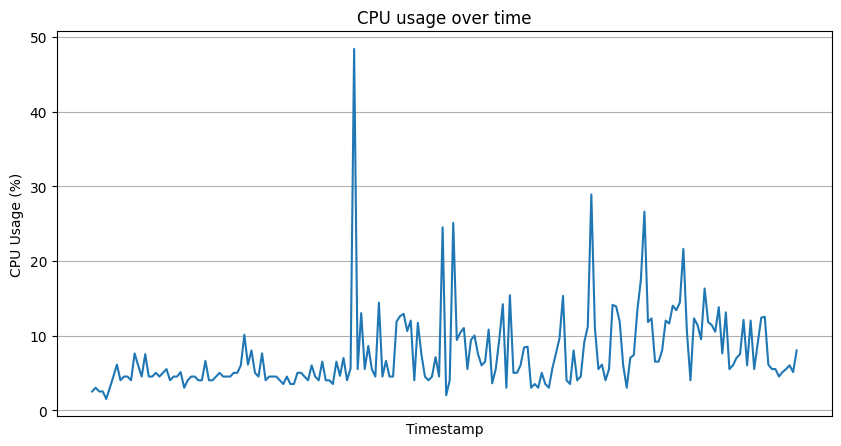

In [65]:
import matplotlib.pyplot as plt

cpu_usage_values = [hit["_source"]["cpu_usage"] for hit in hits]
timestamp_values = [hit["_source"]["@timestamp"] for hit in hits]

plt.figure(figsize=(10, 5))
plt.plot(timestamp_values, cpu_usage_values)
plt.xticks([])
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage (%)")
plt.title("CPU usage over time")
plt.grid(True)
plt.show()

## Aggregations

In [66]:
response = es.search(
    index="cpu_usage_data",
    body={
        "aggs": {
            "avg_cpu_usage": {
                "avg": {
                    "field": "cpu_usage"
                }
            }
        },
    },
)
average_cpu_usage = response.body["aggregations"]["avg_cpu_usage"]["value"]
print(f"Average CPU usage: {average_cpu_usage}%")

Average CPU usage: 7.526499993801117%


In [67]:
response = es.search(
    index="cpu_usage_data",
    body={
        "aggs": {
            "max_cpu_usage": {
                "max": {
                    "field": "cpu_usage"
                }
            }
        },
    },
)
max_cpu_usage = response.body["aggregations"]["max_cpu_usage"]["value"]
print(f"Max CPU usage: {max_cpu_usage}%")

Max CPU usage: 48.400001525878906%
